# Trip Advisor Hotel Review Predictive Modelling

## Purpose

The purpose of this project is to predict hotel ratings from customer reviews. The dataset is form TripAdvisor, with about 20,000 reviews and ratings from 1-5 (1 being the worst and 5 being the best). This can be vital for future customers as they are searching for the right hotel for their stay. For this project, we will utilize NLP with a deep neural network using tensorflow. 

### Load Libraries

In [27]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import nltk
from nltk import pos_tag, word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
import re
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l2
from keras.layers import Embedding, Dense, Dropout, LSTM, Bidirectional
from keras.models import Sequential
import pickle

### Initial EDA

In [2]:
hotelreview = pd.read_csv("tripadvisor_hotel_reviews.csv")
hotelreview.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [3]:
hotelreview.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB


In [4]:
hotelreview.duplicated().sum()

0

From the results above, we can observe that there are no null values, and no duplicated values.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0, 0, '1421'),
 Text(0, 0, '1793'),
 Text(0, 0, '2184'),
 Text(0, 0, '6039'),
 Text(0, 0, '9054')]

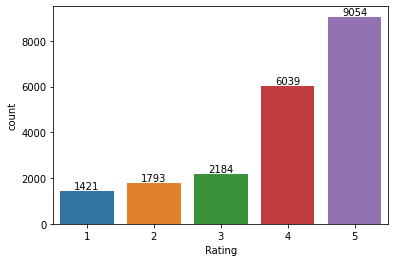

In [5]:
count_rating = sns.countplot(hotelreview["Rating"])
count_rating.bar_label(count_rating.containers[0])

From this above bar graph, we can see that a majority of the ratings are under 4 and 5.

In [6]:
hotelreview.describe()

,Rating
count,20491.000000
mean,3.952223
std,1.233030
min,1.000000
25%,3.000000
50%,4.000000
75%,5.000000
max,5.000000


In [7]:
# Shows the length of each review
hotelreview["Review_Length"] = hotelreview["Review"].map(lambda x : len(x))
hotelreview.head()

,Review,Rating,Review_Length
0,nice hotel expensive parking got good deal sta...,4,593
1,ok nothing special charge diamond member hilto...,2,1689
2,nice rooms not 4* experience hotel monaco seat...,3,1427
3,"unique, great stay, wonderful time hotel monac...",5,600
4,"great stay great stay, went seahawk game aweso...",5,1281


In [8]:
# Shows the maximum length of each rating category in descending order
maxLen = hotelreview.groupby("Rating")["Review_Length"].max().reset_index().sort_values(by = "Review_Length", ascending=False, ignore_index=True)
maxLen

,Rating,Review_Length
0,3,13501
1,5,12738
2,4,10062
3,2,7802
4,1,6511


In [9]:
# Shows the minimum length of each rating category in descending order
minLen = hotelreview.groupby("Rating")["Review_Length"].min().reset_index().sort_values(by = "Review_Length", ascending=True, ignore_index=True)
minLen

,Rating,Review_Length
0,5,44
1,3,47
2,4,61
3,2,74
4,1,77


In [14]:
hotelreview.columns

Index(['Review', 'Rating', 'Review_Length'], dtype='object')

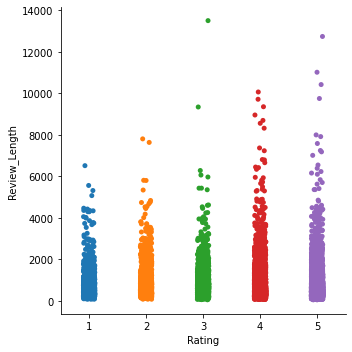

In [15]:
sns.catplot(data=hotelreview, x="Rating", y="Review_Length")

It is interesting to note that a rating of 3 has the most spread among all the ratings, and a rating of 5 also has a similar spread to a rating of 3. A rating of 1 has the least amount of spread compared to all the ratings. This could be due to if a person gave a rating of 3, they could point out what they liked and disliked about the hotel. For a rating of 5, a customer could have either put very few words like "Great stay", or put in a lengthy description of why they were so satisfied with the stay. Lastly, if a customer put a rating of 1, they could have been so dissatisfied with the hotel that they did not want to put much time to write as much.

In [16]:
def categorize_rating(rating):
    if rating > 3:
        return 'Satisfied'
    elif rating == 3:
        return 'Neutral'
    else:
        return 'Not Satisfied'

In [17]:
hotelreview['Rating'] = hotelreview['Rating'].apply(categorize_rating)

We separated the target variable into 3 categories: "Satisfied", "Neutral", and "Not Satisfied". If the review had a rating of above 3, that would be labeled as "Satisfied", a rating of 3 is labeled as "Neutral", and a rating below 3 would be "Not Satisfied". Since ratings of 4 and 5 would be somewhat similar, and ratings of 1 and 2 would also be relatively similar, we decided to group them together generalize the categories for the prediction analysis. 

### Text Preprocessing

In [18]:
# Use the NLTK library to get the English stopwords
sw = nltk.corpus.stopwords.words('english')

In [19]:
# Remove stopwords function
def rm_stopword(x):
    result = [i for i in x if i not in sw]
    return result

In [20]:
# Lemmatization (so that word doesn't lose meaning after stemming)
word_lemmatize = WordNetLemmatizer()

In [21]:
# Create tags of different parts of speech so that it knows how to lemmatize all of the words
def create_tag(tags):
    convert_tag = {'NN':'n', 'JJ':'a', 'VB': 'v', 'RB': 'r'}
    try:
        return convert_tag[tags[:2]]
    except:
        return 'n'

def lemmatize_sentence(text):
    return [word_lemmatize.lemmatize(word.lower(), pos = create_tag(tag))
    for word, tag in pos_tag(word_tokenize(text))]

In [22]:
# Clean the review text function
def clean_text(rev):
    rev = re.sub('[^a-zA-Z0-9]', ' ', rev)
    rev = re.compile(r"\s+").sub(' ', rev)
    rev = rev.lower().split()
    rev = rm_stopword(rev)
    # join words back together to lemmatize based on tags
    full = ' '.join(rev)
    full = lemmatize_sentence(full)
    # rejoin the words have it being separated
    full = ' '.join(full)
    return full


In [23]:
# Apply the cleaning function and create a new column called "Clean_Text"
hotelreview["Clean_Text"] = hotelreview["Review"].apply(clean_text)
hotelreview.head()

,Review,Rating,Review_Length,Clean_Text
0,nice hotel expensive parking got good deal sta...,Satisfied,593,nice hotel expensive parking get good deal sta...
1,ok nothing special charge diamond member hilto...,Not Satisfied,1689,ok nothing special charge diamond member hilto...
2,nice rooms not 4* experience hotel monaco seat...,Neutral,1427,nice room 4 experience hotel monaco seattle go...
3,"unique, great stay, wonderful time hotel monac...",Satisfied,600,unique great stay wonderful time hotel monaco ...
4,"great stay great stay, went seahawk game aweso...",Satisfied,1281,great stay great stay go seahawk game awesome ...


In [24]:
# Check to see how the lengths differ after cleaning the text -- the length of text seems to have decreased after cleaning
hotelreview["Review_Length_2"] = hotelreview["Clean_Text"].map(lambda x : len(x))
hotelreview.head()

,Review,Rating,Review_Length,Clean_Text,Review_Length_2
0,nice hotel expensive parking got good deal sta...,Satisfied,593,nice hotel expensive parking get good deal sta...,523
1,ok nothing special charge diamond member hilto...,Not Satisfied,1689,ok nothing special charge diamond member hilto...,1534
2,nice rooms not 4* experience hotel monaco seat...,Neutral,1427,nice room 4 experience hotel monaco seattle go...,1307
3,"unique, great stay, wonderful time hotel monac...",Satisfied,600,unique great stay wonderful time hotel monaco ...,543
4,"great stay great stay, went seahawk game aweso...",Satisfied,1281,great stay great stay go seahawk game awesome ...,1104


In [25]:
hotelreview.describe()

,Review_Length,Review_Length_2
count,20491.000000,20491.000000
mean,724.896833,653.408814
std,689.101024,614.026037
min,44.000000,32.000000
25%,339.000000,309.000000
50%,537.000000,485.000000
75%,859.000000,778.000000
max,13501.000000,12119.000000


In [26]:
# Create new dataframes so that we can put wordclouds together for each category
hotelreview_satisfied = hotelreview[hotelreview["Rating"] == "Satisfied"]
hotelreview_neutral = hotelreview[hotelreview["Rating"] == "Neutral"]
hotelreview_notsatisfied = hotelreview[hotelreview["Rating"] == "Not Satisfied"]

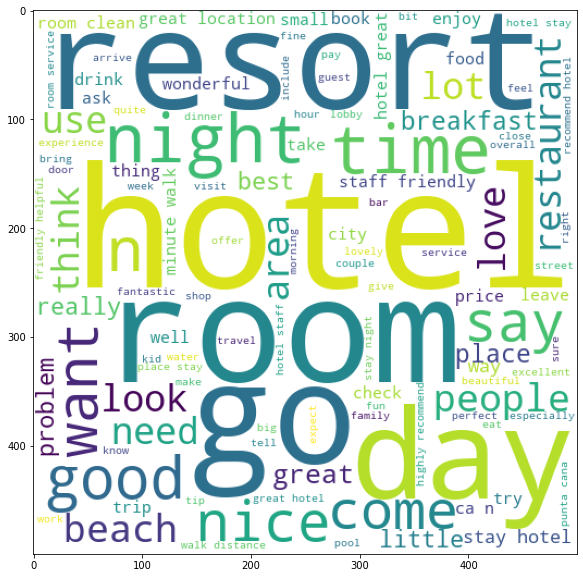

In [33]:
# Word Cloud for Satisfied Reviews
plt.figure(figsize=(10, 10))
wc_satisfied = WordCloud(max_words=1000, min_font_size=10, height=500, width=500, background_color="white").generate(' '.join(hotelreview_satisfied['Clean_Text']))
plt.imshow(wc_satisfied)

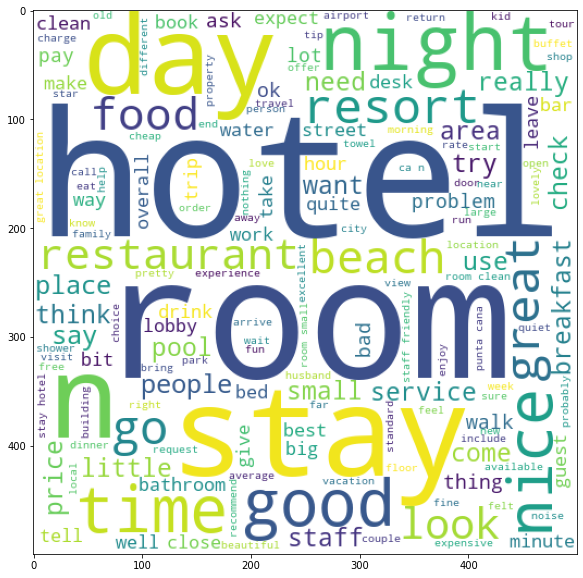

In [34]:
# Word Cloud for Neutral Reviews
plt.figure(figsize=(10, 10))
wc_neutral = WordCloud(max_words=1000, min_font_size=10, height=500, width=500, background_color="white").generate(' '.join(hotelreview_neutral['Clean_Text']))
plt.imshow(wc_neutral)

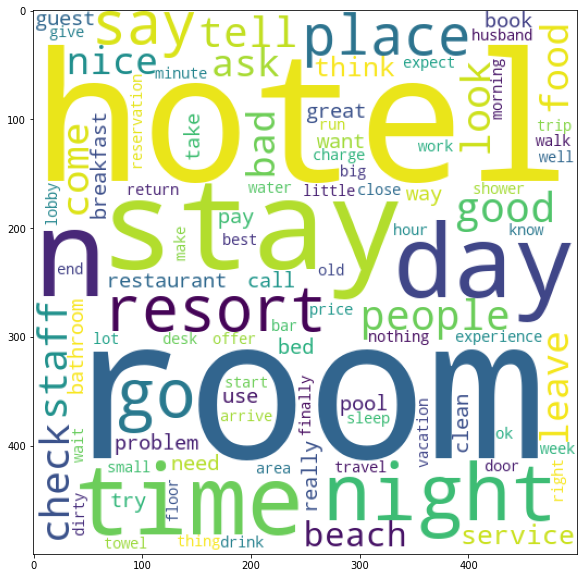

In [35]:
# Word Cloud for Not Satisfied Reviews
plt.figure(figsize=(10, 10))
wc_notsatisfied = WordCloud(max_words=1000, min_font_size=10, height=500, width=500, background_color="white").generate(' '.join(hotelreview_notsatisfied['Clean_Text']))
plt.imshow(wc_notsatisfied)

As we look at the 3 different word clouds for each category, we can see that there are the main words that are apparent in all categories which are hotel, room, and day. However, once it comes down to the details, there are observations of positive words in "Satisfied", a few complaints but positive words in "Neutral", and more negative words in "Not Satisfied".

In [36]:
# Drop columns we don't need and rename "Clean_Text" to "Review"
hotelreview.drop(['Review','Review_Length', 'Review_Length_2'], axis = 1, inplace=True)
hotelreview = hotelreview.rename(columns={"Clean_Text": "Review"})

In [37]:
X = hotelreview["Review"]
y = hotelreview["Rating"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)

In [38]:
print('X training data: ', X_train.shape, '; ', 'y training data: ', y_train.shape, '; ', 'X testing data: ', X_test.shape, '; ', 'y testing data: ', y_test.shape)

X training data:  (16392,) ;  y training data:  (16392,) ;  X testing data:  (4099,) ;  y testing data:  (4099,)


### Tokenize and Vectorize

In [39]:
# Each text will be converted to a sequence of integers and padded with zeroes in front for all sequences to be the same length 
tokenizer = Tokenizer(num_words=50000, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)
vocab_len = len(tokenizer.word_index)
print('Total Number of Unique Words: {}'.format(vocab_len))
train_sequence = tokenizer.texts_to_sequences(X_train)
train_paddedseq = pad_sequences(train_sequence)

test_sequence = tokenizer.texts_to_sequences(X_test)
test_paddedseq = pad_sequences(test_sequence)
# Utilize LabelBinarizer to binarize labels in a one vs all fashion
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.fit_transform(y_test)

Total Number of Unique Words: 40935


In [40]:
pickle.dump(tokenizer, open('tokenizer.pkl', 'wb'))
pickle.dump(lb, open('label.pkl', 'wb'))

### Modeling

In [41]:
model = Sequential()
model.add(Embedding(vocab_len+1, 16))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.5)) # Inputs not set to 0 are scaled up by 1/(1-rate)
model.add(Dense(16, activation = 'relu', kernel_regularizer= l2(0.0015)))#, bias_regularizer=l2(0.001)))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))
model.summary()

2023-02-09 17:25:29.723618: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          654976    
                                                                 
 bidirectional (Bidirectiona  (None, 64)               12544     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 16)                1040      
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 3)                 51        
                                                        

In [42]:
model.compile(optimizer=tf.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(train_paddedseq, y_train, epochs=7, validation_data=(test_paddedseq, y_test))

Epoch 1/7
513/513 [==============================] - 317s 608ms/step - loss: 0.6742 - accuracy: 0.7745 - val_loss: 0.4776 - val_accuracy: 0.8226
Epoch 2/7
513/513 [==============================] - 294s 573ms/step - loss: 0.4344 - accuracy: 0.8532 - val_loss: 0.4678 - val_accuracy: 0.8341
Epoch 3/7
513/513 [==============================] - 287s 561ms/step - loss: 0.3703 - accuracy: 0.8688 - val_loss: 0.4891 - val_accuracy: 0.8270
Epoch 4/7
513/513 [==============================] - 283s 551ms/step - loss: 0.3165 - accuracy: 0.8806 - val_loss: 0.5663 - val_accuracy: 0.8265
Epoch 5/7
513/513 [==============================] - 281s 548ms/step - loss: 0.2703 - accuracy: 0.8985 - val_loss: 0.6621 - val_accuracy: 0.8312
Epoch 6/7
513/513 [==============================] - 278s 542ms/step - loss: 0.2526 - accuracy: 0.9107 - val_loss: 0.6482 - val_accuracy: 0.8075
Epoch 7/7
513/513 [==============================] - 275s 536ms/step - loss: 0.2247 - accuracy: 0.9228 - val_loss: 0.7970 - val_ac

In [43]:
pred = model.predict(test_paddedseq)
true_labels = np.argmax(y_test, axis = -1)
pred_labels = np.argmax(pred, axis = -1)

129/129 [==============================] - 19s 144ms/step


In [44]:
print(classification_report(true_labels, pred_labels))

              precision    recall  f1-score   support

           0       0.37      0.20      0.26       471
           1       0.76      0.67      0.71       640
           2       0.87      0.96      0.91      2988

    accuracy                           0.83      4099
   macro avg       0.67      0.61      0.63      4099
weighted avg       0.80      0.83      0.81      4099



In [45]:
model.evaluate(test_paddedseq, y_test)

129/129 [==============================] - 19s 143ms/step - loss: 0.7970 - accuracy: 0.8270


[0.7969924807548523, 0.8270309567451477]

In [46]:
model.save('nn_model.h5')

After training our tensorflow model, we end up with about an 83% accuracy rate of predicting the different customer satisfaction categories. We can now use this model to predict the ratings based on customer reviews.

### Predictions

In [47]:
def nn_predict(rating):
    clean_sentence = clean_text(rating)
    seq = tokenizer.texts_to_sequences([clean_sentence])
    pad = pad_sequences(seq)
    pred = model.predict(pad)
    result = lb.inverse_transform(pred)[0] # gets label name
    return result

In [48]:
rating_1 = 'Great and comfortable place to stay'
print(nn_predict(rating_1))

1/1 [==============================] - 1s 1s/step
Satisfied


In [49]:
rating_2 = 'The food was ok, and the scenery was nice'
print(nn_predict(rating_2))

1/1 [==============================] - 0s 26ms/step
Neutral


In [50]:
rating_3 = 'It was in a bad location and the service was horrible'
print(nn_predict(rating_3))

1/1 [==============================] - 0s 19ms/step
Not Satisfied


## Conclusion

As a conclusion, we are able to predict customer satisfaction based on the review they write on TripAdvisor. In this analysis, we performed text preprocessing to use for training our neural network model. We built the model with LSTM (Long Short-Term Memory) and an embedding layer that resulted in a 83% accurate model on testing data. With this model, we can see what the rating will be based on customer reviews and discover key points on what makes hotels satisfactory or not satisfactory. 